Mail: rdekou@gmail.com

Language: Python 3.5.2


In this challenge you are given a csv file, logs.csv , in which each row represents an ad impression event.
uuid is a user ID and ts is the timestamp of the event. This file represents one month of logs from our
advertising platform for a subset of UUIDs.
You can download logs.csv here: https://amadeus.box.com/s/tt3rn4gzb2i046sgtu84ebmyqg14obag


### Problem
This is a "feature engineering" problem. The dataset gives us information about users in raw log form. Using
this data, we would like to compute a few features for each user, which we would eventually use in a machine
learning model (not part of this problem).

We would like you to compute the following features for each user:

    multiple_days: Whether the user is active for multiple days (True/False)
    weekday_biz: Whether the user's traffic tends to occur during weekday business hours (True/False)
    A third feature of your choice. Explore the data and propose something that you think might be useful.

Using the language and tools of your choice, please choose criteria to define the above features, compute
them for each UUID in the logs, and produce output as a .csv file.
Scope


The output should contain values for each feature, for each UUID in logs.csv
Sample output:

uuid,multiple_days,weekday_biz,my_feature

AA1A8BE9-1A64-4E94-A975-A85F38310865,True,False,False

AAA215A0-A51D-4CE5-BAF5-8DE1AD068DBE,True,True,True

AA3D59A6-85CB-484F-A048-4532C88F655E,False,False,False
etc...



In [1]:

import pandas as pd

import time


%matplotlib inline


Load and explore the dataset

In [2]:
log_df = pd.read_csv('./logs.csv')

In [3]:
print(log_df.shape, log_df.drop_duplicates(subset = 'uuid').shape)

(669491, 4) (257354, 4)


In [4]:
log_df.head()

,uuid,ts,ip,useragent
0,AAAFBFB0-8FE9-4C37-964F-0AD7CBBEAF48,2017-07-08 11:54:14,193.232.46.20,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
1,AAAB4ABA-A7FF-4AF2-B89D-0474A372FB10,2017-07-08 11:54:18,80.215.10.165,Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_2 like...
2,AAE4ABAB-9530-4C31-8A3A-C2CA98E4EAFA,2017-07-08 11:54:32,88.125.155.125,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_5 like ...
3,AAA7F528-6651-44C9-8B75-E6B6F2DF5348,2017-07-08 19:31:17,62.42.89.118,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
4,AA6011B0-89CD-4225-8E92-5CE61BB1FC73,2017-07-08 19:31:25,87.170.121.139,Mozilla/5.0 (Android 4.4.4; Tablet; rv:54.0) G...


Investigating missing values

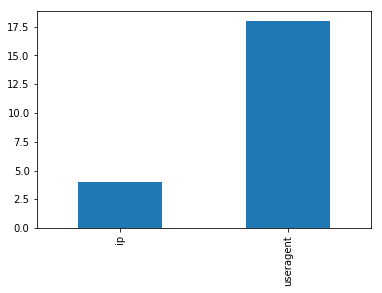

In [5]:
missing = log_df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing
missing.plot.bar()

There is no missing values in the columns of interest 'uuid' and 'ts'

In [6]:
log_df = log_df.drop(['ip', 'useragent'], axis = 1)

In [7]:
log_df.head(3)

,uuid,ts
0,AAAFBFB0-8FE9-4C37-964F-0AD7CBBEAF48,2017-07-08 11:54:14
1,AAAB4ABA-A7FF-4AF2-B89D-0474A372FB10,2017-07-08 11:54:18
2,AAE4ABAB-9530-4C31-8A3A-C2CA98E4EAFA,2017-07-08 11:54:32


Getting event day, hour and day of week from event time

In [8]:
feature0 = ['day', 'hour']


for i in range(len(feature0)):
    
     log_df[feature0[i]] = pd.Series(index=log_df.index)


In [9]:
log_df.day =  pd.to_datetime(log_df.ts, format= '%Y-%m-%d %H:%M:%S.%f').dt.day

log_df.hour =  pd.to_datetime(log_df.ts, format= '%Y-%m-%d %H:%M:%S.%f').dt.hour

log_df['weekday']=  pd.to_datetime(log_df.ts).dt.dayofweek

In [10]:
log_df.tail(5)

,uuid,ts,day,hour,weekday
669486,AAB8DE38-9C48-45D6-A02C-7F5BD267C91F,2017-07-18 23:06:58,18,23,1
669487,AA0583C8-DEC6-49A7-955D-EDE931011672,2017-07-18 23:06:59,18,23,1
669488,AA7B042B-9A2C-4E44-8155-0A2DF069279F,2017-07-18 01:03:18,18,1,1
669489,AAA2881A-F9B4-4B9D-8DAB-BC4B560F4154,2017-07-18 01:03:22,18,1,1
669490,AACCD508-AA61-4F83-BE72-56AA85B23B89,2017-07-18 01:03:29,18,1,1


Grouping the dataframe by user

In [11]:
log_df_group = log_df.groupby('uuid')

Creating new features:

    The number of impression is relevant. It gives an indication of the number of conversions. 

    The CPI (conversion per impression) is a common testing metric across the business

In [12]:
feature1 = ['multiple_days', 'weekday_biz', 'multiple_imp']


for i in range(len(feature1)):
    
     log_df[feature1[i]] = pd.Series('False', index=log_df.index)
  
log_df['n_events'] = pd.Series(0, index=log_df.index)
        

In [13]:
log_df = log_df.drop_duplicates(subset = ['uuid'])

In [14]:


for ind in range(len(log_df.index)): 
    
    if ind%50000 == 0: 
            print('%s'%ind +'/257354')
            
    uuid = log_df.iat[ind, 0] #Getting a user id 
    
    cur_group = log_df_group.get_group((uuid)) #Getting all the events associated with the user id
 
    log_df.iat[ind, 8] = cur_group.ts.count() #number of impressions
    
    if cur_group.ts.count() >1: #more than one impression
        log_df.iat[ind, 7] = 'True'
        
    if cur_group.day.nunique() > 1: #more than one day => multiple days
 
        log_df.iat[ind, 5] = 'True'
    
    biz = 0
    nobiz = 0
    
    
    for i in range(cur_group.day.count()): 
        
        if (cur_group.weekday.values[i]) < 5 and \
           (cur_group.hour.values[i]>=9 ) and (cur_group.hour.values[i]<=17 ) : #Monday till Friday and 9am till 5pm 
            
                biz = biz +1
                
        else: #nights or weekends
            nobiz = nobiz +1
            
    
    if nobiz != 0: 
        if biz/nobiz >1.0: 
            log_df.iat[ind, 6] = 'True'
            
            
    else: 
        log_df.iat[ind, 6] = 'True'

0/257354
50000/257354
100000/257354
150000/257354
200000/257354
250000/257354


In [15]:
log_df.n_events.describe(percentiles = [.5, .72, .9])

count    257354.000000
mean          2.601440
std           8.223889
min           1.000000
50%           1.000000
72%           1.000000
90%           5.000000
max         923.000000
Name: n_events, dtype: float64

Notice that 72 percent of the users have only one impression.

Quick check

In [16]:
log_df[log_df.uuid == 'AAB8DE38-9C48-45D6-A02C-7F5BD267C91F']

,uuid,ts,day,hour,weekday,multiple_days,weekday_biz,multiple_imp,n_events
669486,AAB8DE38-9C48-45D6-A02C-7F5BD267C91F,2017-07-18 23:06:58,18,23,1,False,False,False,1


In [17]:


log_df_group.get_group(('AAB8DE38-9C48-45D6-A02C-7F5BD267C91F'))[['uuid', 'day', 'hour', 'weekday', 'n_events']]

,uuid,day,hour,weekday,n_events
669486,AAB8DE38-9C48-45D6-A02C-7F5BD267C91F,18,23,1,0


In [18]:
log_df[log_df.uuid == 'AA7B042B-9A2C-4E44-8155-0A2DF069279F']

,uuid,ts,day,hour,weekday,multiple_days,weekday_biz,multiple_imp,n_events
243006,AA7B042B-9A2C-4E44-8155-0A2DF069279F,2017-07-18 14:22:35,18,14,1,True,False,True,4


In [19]:


log_df_group.get_group(('AA7B042B-9A2C-4E44-8155-0A2DF069279F'))[['uuid', 'day', 'hour', 'weekday', 'n_events']]

,uuid,day,hour,weekday,n_events
243006,AA7B042B-9A2C-4E44-8155-0A2DF069279F,18,14,1,0
268594,AA7B042B-9A2C-4E44-8155-0A2DF069279F,26,5,2,0
407157,AA7B042B-9A2C-4E44-8155-0A2DF069279F,20,2,3,0
669488,AA7B042B-9A2C-4E44-8155-0A2DF069279F,18,1,1,0


In [20]:
log_df[log_df.uuid == 'AA98C3D7-33F3-4C35-9783-721B664B479A']

,uuid,ts,day,hour,weekday,multiple_days,weekday_biz,multiple_imp,n_events
92,AA98C3D7-33F3-4C35-9783-721B664B479A,2017-07-08 09:36:16,8,9,5,True,False,True,4


In [21]:


log_df_group.get_group(('AA98C3D7-33F3-4C35-9783-721B664B479A'))[['uuid', 'day', 'hour', 'weekday', 'n_events']]

,uuid,day,hour,weekday,n_events
92,AA98C3D7-33F3-4C35-9783-721B664B479A,8,9,5,0
177301,AA98C3D7-33F3-4C35-9783-721B664B479A,4,9,1,0
177302,AA98C3D7-33F3-4C35-9783-721B664B479A,4,9,1,0
570664,AA98C3D7-33F3-4C35-9783-721B664B479A,1,10,5,0


Dropping other columns

In [22]:
log_df = log_df.drop(['ts', 'day', 'hour', 'weekday', 'n_events'], axis = 1)

In [23]:
log_df.head(3)

,uuid,multiple_days,weekday_biz,multiple_imp
0,AAAFBFB0-8FE9-4C37-964F-0AD7CBBEAF48,True,False,True
1,AAAB4ABA-A7FF-4AF2-B89D-0474A372FB10,False,False,False
2,AAE4ABAB-9530-4C31-8A3A-C2CA98E4EAFA,False,False,False


Describing how many users are labeled 'True' for each feature

In [24]:
col = log_df.columns[1:]

for icol in col:
    print ('There are %d'%log_df[log_df[icol] == 'True'].shape[0], 'users labelled True in %s'%icol)

There are 36035 users labelled True in multiple_days
There are 87675 users labelled True in weekday_biz
There are 71980 users labelled True in multiple_imp


In [25]:
for icol in col:
    print ('%0.2f'%(log_df[log_df[icol] == 'True'].shape[0]/log_df.shape[0]), 'percent of users are labelled True in %s'%icol)

0.14 percent of users are labelled True in multiple_days
0.34 percent of users are labelled True in weekday_biz
0.28 percent of users are labelled True in multiple_imp


In [26]:

log_df.shape

(257354, 4)

In [28]:
log_df.to_csv('./output.csv', index= False)